Library required

In [2]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

Load file

In [5]:
RESUME_TXT_PATH = "data/resume.txt"
JOBS_CSV_PATH   = "data/jobs.csv"

resume_text = Path(RESUME_TXT_PATH).read_text(
    encoding="utf-8",
    errors="ignore"
)

resume_df = pd.DataFrame([
    {
        "resume_id": "0",        # single resume
        "resume_text": resume_text
    }
])

jobs_df   = pd.read_csv(JOBS_CSV_PATH)
# create job_id using row number
jobs_df["job_id"] = jobs_df.index.astype(str)

Data processing 

In [10]:
# change to all lower case, delete all special characters and delete extra spaces in between
def normalize_txt (txt:str)->str:
    txt=(txt or "").lower()
    txt = re.sub(r"[^a-z0-9\s]+", " ", txt)
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

# resume
resume_df["resume_text_norm"] = resume_df["resume_text"].apply(normalize_txt)

# job posting
# only focus on skills and job descriptions, ignore location and company columns for now
jobs_df["job_text_raw"] = jobs_df["description"].fillna("").astype(str)
jobs_df["job_text_norm"] = jobs_df["job_text_raw"].apply(normalize_txt)


Embedding

In [14]:
model = SentenceTransformer("all-MiniLM-L6-v2")

resume_emb = model.encode(
    resume_df["resume_text_norm"].tolist(),
    normalize_embeddings=True
)

job_emb = model.encode(
    jobs_df["job_text_norm"].tolist(),
    normalize_embeddings=True
)

similarity_matrix = cosine_similarity(resume_emb, job_emb)

print("similarity_matrix shape:", similarity_matrix.shape)
# should be (1, number of job posting)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


similarity_matrix shape: (1, 10)


Ranking 

In [17]:
sim_df = (
    pd.DataFrame(
        similarity_matrix,
        index=resume_df["resume_id"],
        columns=jobs_df["job_id"]
    )
    .stack()
    .rename("similarity")
    .reset_index()
)

# attach job title for readability
sim_df = sim_df.merge(
    jobs_df[["job_id", "title"]],
    on="job_id",
    how="left"
)

# Example: get Top-K jobs for one resume
TOP_K = 10

top_matches = (
    sim_df
    .sort_values("similarity", ascending=False)
    .head(TOP_K)
    .reset_index(drop=True)
)

top_matches

,resume_id,job_id,similarity,title
0,0,6,0.445640,AI & Analytics Intern
1,0,9,0.444854,Product Data Intern
2,0,1,0.439175,Data Analyst Co-op
3,0,4,0.407507,Business Intelligence Intern
4,0,3,0.376227,Data Science Intern
5,0,5,0.370239,Cloud Data Intern
6,0,8,0.305779,Operations Data Intern
7,0,0,0.254474,Data Engineer Intern
8,0,7,0.226543,Backend/Data Intern
9,0,2,0.175851,Software Engineer Intern


Visulization 

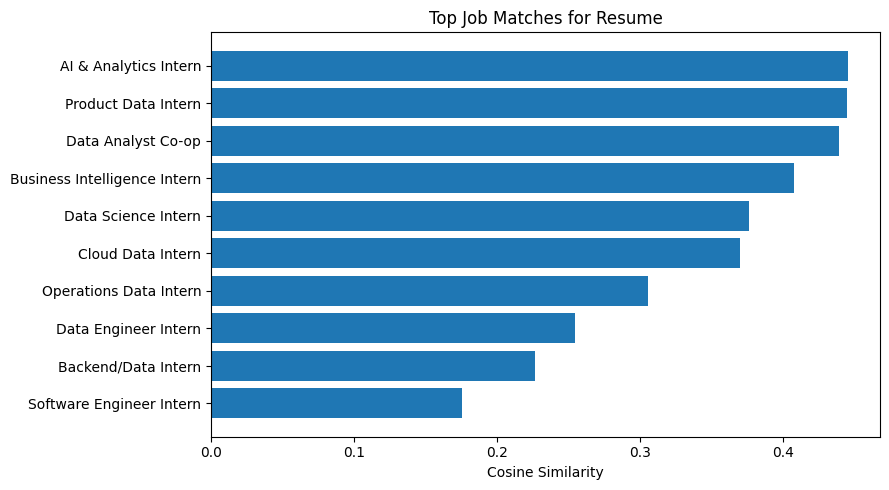

In [21]:
def plot_topk_similarity_horizontal(sim_df, k=10):
    tmp = (
        sim_df
        .sort_values("similarity", ascending=False)
        .head(k)
        .sort_values("similarity", ascending=True)
        .copy()
    )

    tmp["title_short"] = tmp["title"].fillna("").astype(str).apply(
        lambda s: s[:50] + "..." if len(s) > 50 else s
    )

    plt.figure(figsize=(9, 5))
    plt.barh(tmp["title_short"], tmp["similarity"])
    plt.xlabel("Cosine Similarity")
    plt.title("Top Job Matches for Resume")
    plt.tight_layout()
    plt.show()

plot_topk_similarity_horizontal(sim_df, k=10)